# 1) Download required files 

In [1]:
%%bash
git clone https://github.com/azzubair01/invoice-dataset.git
mv invoice-dataset/dataset ./
mv invoice-dataset/label_map.pbtxt ./
cd dataset
unzip train.zip
mv train images

Archive:  train.zip
   creating: train/
  inflating: train/Invoice_1.jpg     
  inflating: train/Invoice_10.jpg    
  inflating: train/Invoice_100.jpg   
  inflating: train/Invoice_100_affine_translation.jpg  
  inflating: train/Invoice_100_brightness.jpg  
  inflating: train/Invoice_100_gaussianblur.jpg  
  inflating: train/Invoice_100_horizontallyflip.jpg  
  inflating: train/Invoice_101.jpg   
  inflating: train/Invoice_101_affine_translation.jpg  
  inflating: train/Invoice_101_brightness.jpg  
  inflating: train/Invoice_101_gaussianblur.jpg  
  inflating: train/Invoice_101_horizontallyflip.jpg  
  inflating: train/Invoice_102.jpg   
  inflating: train/Invoice_102_affine_translation.jpg  
  inflating: train/Invoice_102_brightness.jpg  
  inflating: train/Invoice_102_gaussianblur.jpg  
  inflating: train/Invoice_102_horizontallyflip.jpg  
  inflating: train/Invoice_103.jpg   
  inflating: train/Invoice_103_affine_translation.jpg  
  inflating: train/Invoice_103_brightness.jpg  
  in

Cloning into 'invoice-dataset'...


In [2]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2021-02-15 20:42:34--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0s      

2021-02-15 20:42:35 (35.7 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



# 2) Extract the saved model

In [9]:
%%bash
unzip saved_model_frcnn_v1.zip

Archive:  saved_model_frcnn_v1.zip
   creating: content/inference_graph/saved_model/
   creating: content/inference_graph/saved_model/assets/
   creating: content/inference_graph/saved_model/variables/
  inflating: content/inference_graph/saved_model/variables/variables.index  
  inflating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
  inflating: content/inference_graph/saved_model/saved_model.pb  


# 3) Recall model configurations

In [10]:
output_directory = 'inference_graph'
labelmap_path = 'label_map.pbtxt'

import tensorflow as tf
from object_detection.utils import label_map_util
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'content/{output_directory}/saved_model')

# 4) Select images to be tested

In [11]:
import pandas as pd
test = pd.read_csv('dataset/test_labels.csv')
#Getting 3 random images to test
images = list(test.sample(n=3)['filename'])
images

['Invoice_5_brightness.jpg',
 'Invoice_91_gaussianblur.jpg',
 'Invoice_48_affine_translation.jpg']

# 5) Test the detection model

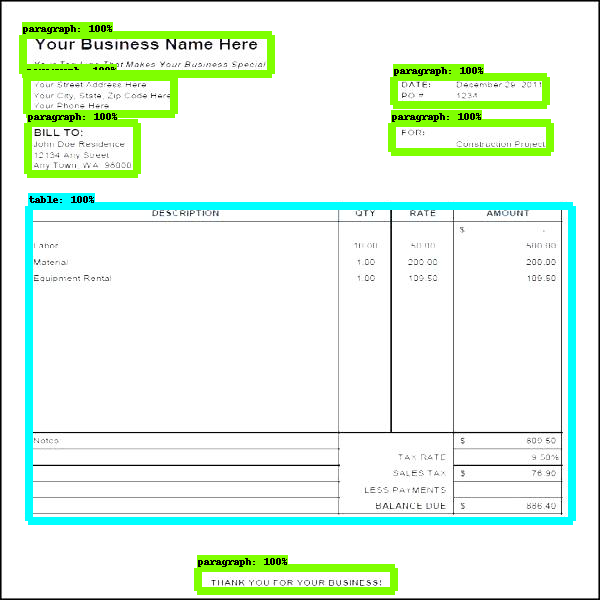

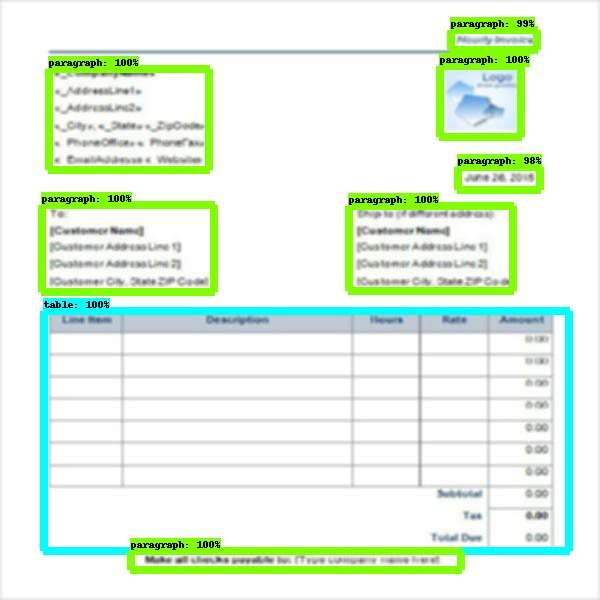

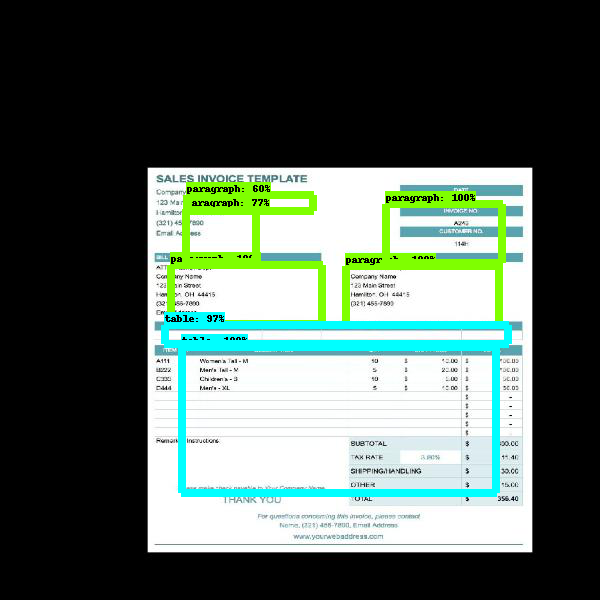

In [14]:
for image_name in images:
    image_np = load_image_into_numpy_array('dataset/images/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)
    display(Image.fromarray(image_np))



# 12) Export the predicted coordinates as CSV file

In [15]:
rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
for image_name in images:
  
    image_np = load_image_into_numpy_array('dataset/images/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)

    # store boxes in dataframe!
    cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))

    for j in range(cut_off_scores):
        name = image_name
        scores = output_dict['detection_scores'][j]
        classes = output_dict['detection_classes'][j]
        for i in range(1,len(category_index)+1):
            if output_dict['detection_classes'][j] == category_index[i]['id']:
                classes = category_index[i]['name']
        ymin = output_dict['detection_boxes'][j][0]
        xmin = output_dict['detection_boxes'][j][1]
        ymax = output_dict['detection_boxes'][j][2]
        xmax = output_dict['detection_boxes'][j][3]

        row = list([name, scores, classes, ymin, xmin, ymax, xmax])
        rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('predicted_coordinates.csv', index = False)
final_df

,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,Invoice_5_brightness.jpg,0.999903,table,0.344112,0.047327,0.867081,0.954872
1,Invoice_5_brightness.jpg,0.999800,paragraph,0.129495,0.655347,0.174442,0.910389
2,Invoice_5_brightness.jpg,0.999755,paragraph,0.129855,0.044935,0.188909,0.290319
3,Invoice_5_brightness.jpg,0.999415,paragraph,0.205573,0.046518,0.288940,0.228953
4,Invoice_5_brightness.jpg,0.999323,paragraph,0.059290,0.036871,0.122050,0.452057
5,Invoice_5_brightness.jpg,0.998779,paragraph,0.206568,0.651775,0.252483,0.917538
6,Invoice_5_brightness.jpg,0.996180,paragraph,0.948039,0.328371,0.984915,0.657875
7,Invoice_5_brightness.jpg,0.326099,table,0.321460,0.111547,0.866703,0.622929
8,Invoice_5_brightness.jpg,0.277221,paragraph,0.295585,0.575218,0.343554,0.878052
9,Invoice_91_gaussianblur.jpg,0.999848,paragraph,0.110415,0.733247,0.227238,0.869825
